In [1]:
import os
import sys
from pathlib import  Path

import zipfile
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import  train_test_split

import tensorflow
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization, Input, Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing, Rescaling

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives
from tensorflow.keras.metrics import TrueNegatives, Precision, Recall, AUC, binary_accuracy

from tensorflow.keras.optimizers import Adam, RMSprop, Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1

from tensorboard.plugins.hparams import api as hp

from helper import *

In [2]:
import wandb
from wandb.keras import WandbCallback

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
d_set = tf.data.Dataset.range(10)
print(list(d_set.as_numpy_iterator()))

ll = len(list(d_set.as_numpy_iterator()))

tr_d_set = d_set.take(int(ll*0.6))
print(list(tr_d_set.as_numpy_iterator()))

val_d_set = d_set.skip(int(ll*0.6))
val_set = val_d_set.take(int(ll*0.2))
print(list(val_set.as_numpy_iterator()))

ts_d_set = val_d_set.skip(int(ll*0.2))
print(list(ts_d_set.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]


In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.2


train_dataset, val_dataset = splits(
    ds_train, TRAIN_RATIO, VAL_RATIO)
# print(list(train_dataset.take(1).as_numpy_iterator()),
#     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

In [6]:
print(list(train_dataset.take(1).as_numpy_iterator()),
    list(val_dataset.take(1).as_numpy_iterator()))

[(array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
    

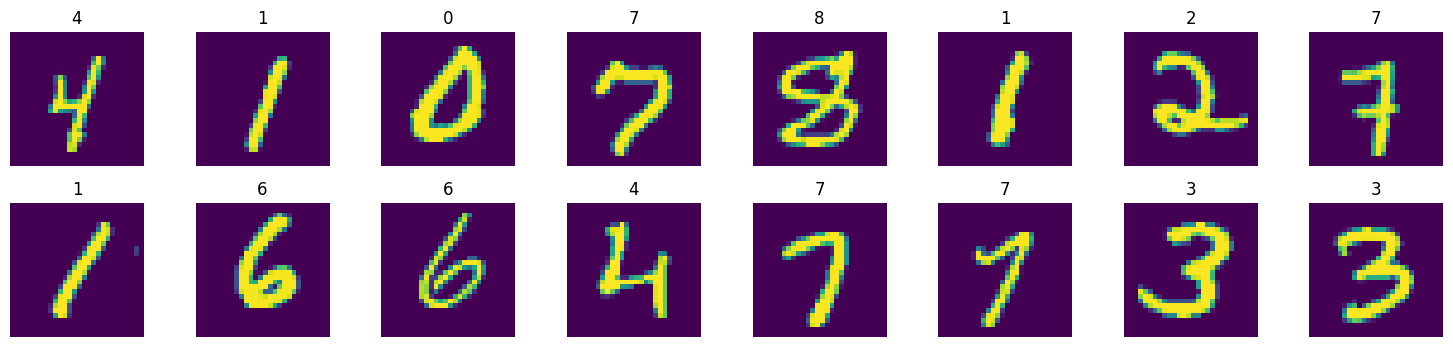

In [7]:
plt.figure(figsize=(15,7))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(image)
  plt.title(ds_info.features['label'].int2str(label.numpy()))
  plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
CONFIGURATION = {
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 5,
    "BATCH_SIZE": 128,
    "DROPOUT_RATE": 0.0,
    "IM_SIZE": 24,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
}


In [9]:
def resize_rescale(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [10]:
for image, label in train_dataset.take(1):
    print(image)

tf.Tensor(
[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  

In [11]:
train_ = train_dataset.map(resize_rescale)
train_data = train_.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

val_ = val_dataset.map(resize_rescale)
validation_data = val_.shuffle(
    buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

test_ = ds_test.map(resize_rescale)
# test_data = test_.shuffle(
#     buffer_size=8, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

In [12]:
for image, label in train_data.take(1):
    print(image)

tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience = 20,
    verbose=1,
    mode = 'auto',
    baseline= None,
    restore_best_weights = True
)

In [14]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(28,28,1)),
    
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 batch_normalization (Batch  (None, 24, 24, 6)         24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 16)          64        
 chNormalization)                                                
                                                        

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [16]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    verbose=2,
    callbacks=[early_stopping]
    )

Epoch 1/20



375/375 - 10s - loss: 0.9127 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.8649 - val_sparse_categorical_accuracy: 0.7678 - 10s/epoch - 26ms/step
Epoch 2/20
375/375 - 6s - loss: 0.2919 - sparse_categorical_accuracy: 0.9224 - val_loss: 0.2162 - val_sparse_categorical_accuracy: 0.9423 - 6s/epoch - 17ms/step
Epoch 3/20
375/375 - 6s - loss: 0.1859 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.1541 - val_sparse_categorical_accuracy: 0.9564 - 6s/epoch - 16ms/step
Epoch 4/20
375/375 - 6s - loss: 0.1386 - sparse_categorical_accuracy: 0.9623 - val_loss: 0.1240 - val_sparse_categorical_accuracy: 0.9645 - 6s/epoch - 16ms/step
Epoch 5/20
375/375 - 6s - loss: 0.1112 - sparse_categorical_accuracy: 0.9697 - val_loss: 0.1052 - val_sparse_categorical_accuracy: 0.9693 - 6s/epoch - 16ms/step
Epoch 6/20
375/375 - 6s - loss: 0.0924 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.0925 - val_sparse_categorical_accuracy: 0.9734 - 6s/epoch - 16ms/step
Epoch 7/20
375/375 - 6s - loss: 0.0782 - sp

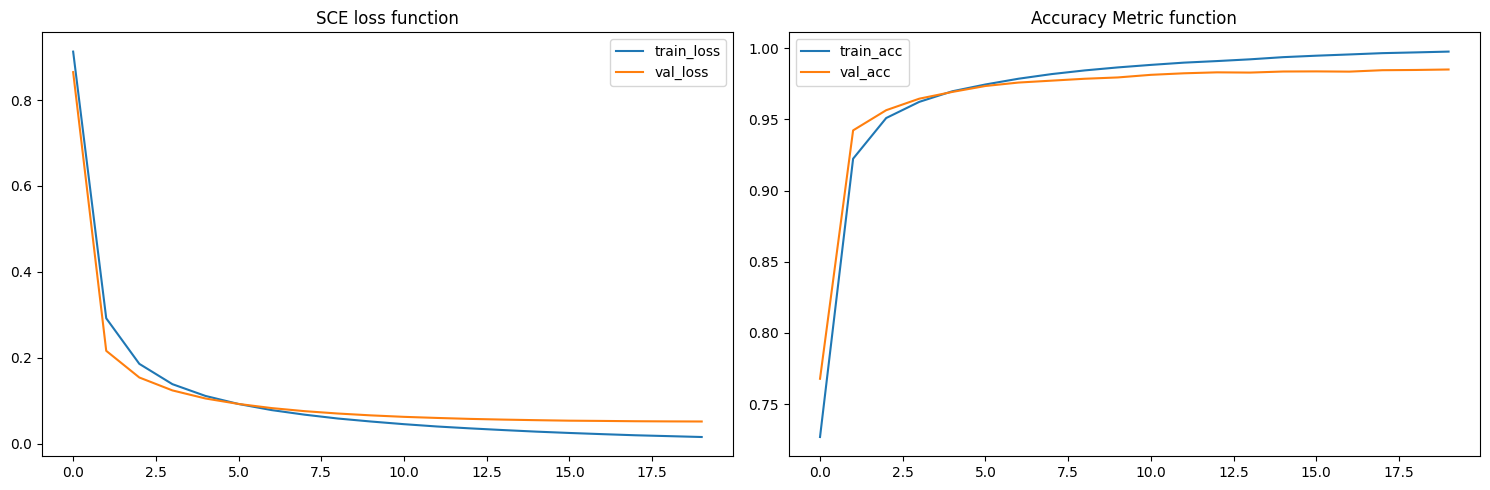

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['loss'], label="train_loss")
ax[0].plot(history.history['val_loss'], label="val_loss")
ax[0].set_title("SCE loss function")
ax[0].legend()

ax[1].plot(history.history['sparse_categorical_accuracy'], label="train_acc")
ax[1].plot(history.history['val_sparse_categorical_accuracy'], label="val_acc")
ax[1].set_title("Accuracy Metric function")
ax[1].legend()
plt.tight_layout()
plt.show()

In [18]:
test_data = test_.batch(1)

In [19]:
model.evaluate(test_data)

10000/10000 [==============================] - 30s 3ms/step - loss: 0.0473 - sparse_categorical_accuracy: 0.9852


[0.047344058752059937, 0.9851999878883362]

In [20]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score,precision_score,recall_score,roc_curve

In [21]:
y_pred = model.predict(test_data)

10000/10000 [==============================] - 36s 4ms/step


In [22]:
y_pred.shape

(10000, 10)

In [26]:
list(test_data.as_numpy_iterator())[0][1][0]

2

In [27]:
import numpy as np

label_list = []

for data_batch, label_batch in list(test_.as_numpy_iterator()):
    label_list.append(label_batch)

# test_labels = np.concatenate(label_list, axis=0)

In [28]:
len(label_list)

10000

In [29]:
test_labels=label_list.copy()

In [30]:
pred_labels = []
pred_probs = []
for probs in y_pred:
    pred_labels.append(np.argmax(probs))
    pred_probs.append(np.max(probs))

In [31]:
y_pred[0]

array([1.9685828e-07, 1.5108887e-07, 9.9999416e-01, 2.1877693e-08,
       2.4090386e-07, 8.5759659e-08, 1.4508231e-08, 5.0446086e-08,
       3.8188136e-06, 1.2787241e-06], dtype=float32)

In [32]:
print(pred_labels[0])
print(pred_probs[0])

2
0.99999416


In [33]:
for image, label in test_data.take(1):
    print(image,label)

tf.Tensor(
[[[[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.        ]
   [0.   

1/1 [==============================] - 0s 17ms/step


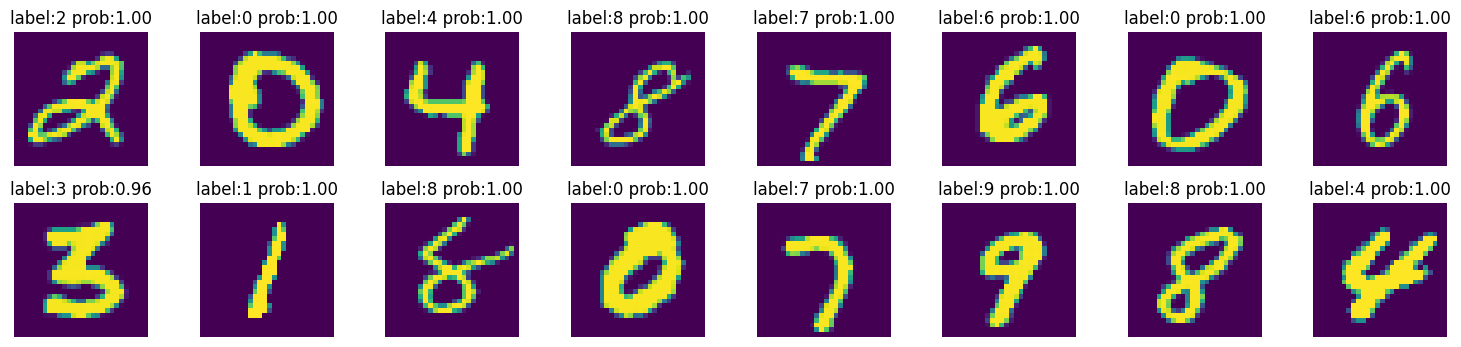

In [36]:
plt.figure(figsize=(15, 7))
for i, (image, label) in enumerate(test_data.take(16)):
  ax = plt.subplot(4, 8, i + 1)

  plt.imshow(tf.squeeze(image, axis=0))
  pred_prob_lst = model.predict(image)
  
  pred_label = np.argmax(pred_prob_lst)
  pred_prob = np.max(pred_prob_lst)
  
  plt.title(f"label:{pred_label} prob:{pred_prob:.2f}")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [37]:
model.predict(test_data.take(1))

1/1 [==============================] - 0s 65ms/step


array([[1.9685828e-07, 1.5108887e-07, 9.9999416e-01, 2.1877693e-08,
        2.4090386e-07, 8.5759659e-08, 1.4508231e-08, 5.0446086e-08,
        3.8188136e-06, 1.2787241e-06]], dtype=float32)

In [48]:
func_input = Input(shape=(28, 28, 1), name="Input Image")


x =    tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu')(func_input)
x =    tf.keras.layers.BatchNormalization()(x)
x =   tf.keras.layers.MaxPooling2D(pool_size=(
        2, 2), strides=(2, 2), padding='valid')(x)

x =   tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(
        1, 1), padding='valid', activation='relu')(x)
x =   tf.keras.layers.BatchNormalization()(x)
x =   tf.keras.layers.MaxPooling2D(pool_size=(
        2, 2), strides=(2, 2), padding='valid')(x)

x =    tf.keras.layers.Flatten()(x)

x =    tf.keras.layers.Dense(120, activation='relu')(x)
x =    tf.keras.layers.BatchNormalization()(x)
x =    tf.keras.layers.Dense(84, activation='relu')(x)
x =    tf.keras.layers.BatchNormalization()(x)
func_output = tf.keras.layers.Dense(10, activation='softmax')(x)


lenet_model_func = Model(func_input, func_output, name="Lenet_Model_Func")

lenet_model_func.summary()

Model: "Lenet_Model_Func"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 6)         156       
                                                                 
 batch_normalization_18 (Ba  (None, 24, 24, 6)         24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 12, 12, 6)         0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_19 (Ba  (None, 8, 8, 16)     

In [56]:
class FeatureExtractor(Layer):
    def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
        super(FeatureExtractor,self).__init__()
        
        self.conv_1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.maxpool_1 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)
        
        self.conv_2 = tf.keras.layers.Conv2D(filters=filters*2+4, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.maxpool_2 = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides*2, padding=padding)
        
    def call(self,x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.maxpool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.maxpool_2(x)
        
        return x
    

class ModelExtractor(Model):
    def __init__(self):
        super(ModelExtractor, self).__init__()

        self.fetaure_extractor = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)
        
        self.flatten = tf.keras.layers.Flatten()

        self.dense_1 = tf.keras.layers.Dense(120, activation='relu')
        self.batch_1 = tf.keras.layers.BatchNormalization()
        self.dense_2 = tf.keras.layers.Dense(84, activation='relu')
        self.batch_2 = tf.keras.layers.BatchNormalization()
        self.dense_3 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, x, training):
        x = self.fetaure_extractor(x)
        x = self.flatten(x)
        
        x = self.dense_1(x)
        x = self.batch_1(x)
        
        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x
    
feature_sub_classed = FeatureExtractor(filters=6,
                                       kernel_size=5,
                                       strides=1,
                                       padding='valid',
                                       activation='relu',
                                       pool_size=2)

model_sub_classed = ModelExtractor()

In [62]:
func_input = Input(shape=(28, 28, 1), name="Input Image")


x = feature_sub_classed(func_input)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(120, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(84, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
func_output = tf.keras.layers.Dense(10, activation='softmax')(x)


lenet_model_subclass = Model(
    func_input, func_output, name="Lenet_Model_Subclass")

lenet_model_subclass.summary()

Model: "Lenet_Model_Subclass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 feature_extractor_9 (Featu  (None, 4, 4, 16)          2660      
 reExtractor)                                                    
                                                                 
 flatten_9 (Flatten)         (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 120)               30840     
                                                                 
 batch_normalization_46 (Ba  (None, 120)               480       
 tchNormalization)                                               
                                                                 
 dense_28 (Dense)            (None, 84)       

In [63]:
func_input = Input(shape=(28, 28, 1), name="Input Image")

func_output = model_sub_classed(func_input)

lenet_model_sub_classed = Model(func_input, func_output, name="Lenet_Model_sub_classed")

lenet_model_sub_classed.summary()

Model: "Lenet_Model_sub_classed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 


 model_extractor_1 (ModelEx  (None, 10)                45330     
 tractor)                                                        
                                                                 
Total params: 45330 (177.07 KB)
Trainable params: 44878 (175.30 KB)
Non-trainable params: 452 (1.77 KB)
_________________________________________________________________


In [122]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('val_sparse_categorical_accuracy')>=0.992):
            print("99.5% Accuracy is reached .......Hence Stopping")
            self.model.stop_training=True  
                                                                                   
def schedule_func(epoch,lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Giving call back for accuracy
callbacks = CustomCallback() 

# Giving call back for EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
      
# Logging the losses and metrics data
filename = 'log.csv'
csv_logger = tf.keras.callbacks.CSVLogger(filename, separator=',', append=False)

# Changing Learning Rate with a Scheduler function
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule_func)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
                                                    factor=0.1,
                                                    patience=3,
                                                    verbose=1,
                                                    mode='auto'                                      
                                                )

# Saving the best model and its weights to given path
checkpoint_filepath = 'weights/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                                    filepath=checkpoint_filepath,
                                                                    verbose = 1,
                                                                    save_weights_only=True,
                                                                    save_best_only=True,
                                                                    monitor='val_loss',
                                                                    mode='auto'
                                                                    )

In [123]:
lenet_model_sub_classed.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                metrics=['sparse_categorical_accuracy'])

lenet_model_sub_classed.fit(train_data,
                            validation_data=validation_data,
                            epochs=50,
                            verbose=2,
                            callbacks = [callbacks, 
                                         early_stopping, 
                                         csv_logger, 
                                         lr_scheduler, 
                                         model_checkpoint_callback])

Epoch 1/50



Epoch 1: val_loss improved from inf to 0.07367, saving model to weights/tmp\checkpoint
375/375 - 9s - loss: 0.0690 - sparse_categorical_accuracy: 0.9832 - val_loss: 0.0737 - val_sparse_categorical_accuracy: 0.9821 - lr: 0.0100 - 9s/epoch - 25ms/step
Epoch 2/50

Epoch 2: val_loss improved from 0.07367 to 0.06453, saving model to weights/tmp\checkpoint
375/375 - 7s - loss: 0.0240 - sparse_categorical_accuracy: 0.9924 - val_loss: 0.0645 - val_sparse_categorical_accuracy: 0.9846 - lr: 0.0100 - 7s/epoch - 19ms/step
Epoch 3/50

Epoch 3: val_loss did not improve from 0.06453
375/375 - 7s - loss: 0.0173 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.0758 - val_sparse_categorical_accuracy: 0.9808 - lr: 0.0100 - 7s/epoch - 19ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.06453
375/375 - 7s - loss: 0.0246 - sparse_categorical_accuracy: 0.9924 - val_loss: 0.0732 - val_sparse_categorical_accuracy: 0.9822 - lr: 0.0100 - 7s/epoch - 18ms/step
Epoch 5/50

Epoch 5: val_loss improved 

In [107]:
lenet_model_sub_classed.evaluate(test_data)

   15/10000 [..............................] - ETA: 36s - loss: 3.9736e-08 - sparse_categorical_accuracy: 1.0000 

10000/10000 [==============================] - 25s 2ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9888


[0.05957506597042084, 0.9887999892234802]

In [109]:
lenet_model_sub_classed.save_weights('weights/lenet_weights')
lenet_model_sub_classed.load_weights('weights/lenet_weights')
lenet_model_sub_classed.evaluate(test_data)

In [111]:
lenet_model_sub_classed.load_weights(checkpoint_filepath)
lenet_model_sub_classed.evaluate(test_data)

10000/10000 [==============================] - 29s 3ms/step - loss: 0.0596 - sparse_categorical_accuracy: 0.9888


[0.05957506597042084, 0.9887999892234802]